# Plane Wave Fitting for Slowness Estimation
Last Update: 14$^{th}$ April,2022 

plane wave fitting by iterating over all possible values of phi

In [1]:
# importing the requiered libraries

import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import random


##### initialize no. of receivers, apparent horizontal velocity of sound, max frequency of source 

In [2]:

n_grp=5 # no. of receivers in a subset and not the number of subset
no_of_subsets=5
n_rec=n_grp*no_of_subsets #  ;number of receivers, to be kept odd for first run

rec_pos_act= np.zeros(shape =(n_rec,2))  # Assigning thr actual receiver position

v = 2000 # m/s ### velocity of propagation (in sand)
freq=2 #Hz, max recorded frequency
lamda=v/freq# wavelength
d=100#m,  l=2000m  > 10 times lamda 

##### initialize position of source and  receivers 

In [3]:
#setting source configuration randomly
#np.random.seed(0)
a=random.randint(int(d-d/10),d*5) # sourec distance must be more than or equal to d , limits set here are arbitary within this acceptance
b=random.randint(int(d-d/10),d*5)
src=(b,a)
random.randrange(d-d/10,d*5)

#setting different receiver configurations

#uncomment following line for random distribution
rec_pos_act=np.random.normal(0,100,size=(n_rec,2))


#uncomment following line for linear distribution
for i in range(0,n_rec):
    rec_pos_act[i,1]=0
    rec_pos_act[i,0]=(i-(n_rec-1)/2)*5 #first receievr at (-50,0) last at (50,0), all in line, distance 5 between them 

#uncomment following line for circular distribution    
for i in range(0,int(n_rec/2)):
    rec_pos_act[i,0]=100*cos((2*i)*2*np.pi/n_rec)
    rec_pos_act[int(i+n_rec/2),0]=100*cos((2*i+1)*2*np.pi/n_rec)
    rec_pos_act[i,1]=100*sin((2*i)*2*np.pi/n_rec)
    rec_pos_act[int(i+n_rec/2),1]=100*sin((2*i+1)*2*np.pi/n_rec)




initialize time recordings by time of arrival, introduce noise in time and position

In [4]:


t_rec_ideal = np.zeros(shape =(n_rec,))  # time recorded in each receiver; form: (index of receiver,time) 


t_noise=np.random.normal(0,0.01,size=(n_rec,))

#introduce noise in position
rec_pos_noise=np.random.normal(0,5,size=(n_rec,2))

rec_pos_mes= rec_pos_act + rec_pos_noise  # rec_pos_mes stores[(x1,y1),(x2,y2),..] 



#initialising time recordings

for i in range (0,n_rec):
    t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_mes[0:n_rec,0]-src[0])**2 + (rec_pos_mes[0:n_rec,1]-src[1])**2)/v



### t_Rec_real has form [[rec1 recording], [rec2 recording]]

# introduce noise in time
t_Rec_real=t_rec_ideal #+ t_noise


# time difference between time recordings wrt receiver 1st rec, 
#in the form : time recorded by receiver at ith position - time recorded by 1st receiver 
#t_diff=np.zeros(shape=(n_rec,))
#for i in range(0,n_rec):
 #   t_diff[i]=t_Rec_real[i]-t_Rec_real[0]
    
   
    
    
    

We iterate over all values of the backazimuth $\phi$ such that it minimizes the error expression for 
N receivers:
$\hat{s} = \min_{s}\sum_{i=1}^{N} (\tau_{i} - r_{i}.s)^2 $
where i is the index of the receivers
$\tau_{i}$ is the time difference for $i^{th}$ receiver
where the slowness vector $\vec{s}$ is defined as:
$\vec{s} = (-\frac{\sin{\phi}}{v}, -\frac{\cos{\phi}}{v})$

In [6]:
#function to return the error expression for a particular s, v and given configuration of receivers : 

def sum_of_errors(s_x,s_y,n_rec,rec_loc,time_diff):
    ''' returns the error expression for particular  slowness vector s , apparent horizontal velocity v, receiver positions, and time differences\
        input s in form of s_x and s_y ( x and y coordinate ) \
        input n_rec: number of receivers \
        input rec_loc: 2-D array for receiver location , in form [(x_1,y_1),...(x_n_rec,y_n_rec)]\
        input time_diff: 1-D array for time difference [(t_i)]'''  
    soe=0 # sume of errors
    # find sum over all receivers
    for i in range (0,n_rec):
        soe+=(time_diff[i]-s_x*rec_loc[i,0]-s_y*rec_loc[i,1])**2
    return soe    

In [7]:
#function to estimate slowness by iterating over backazimuth

def estimate_slowness(v,n_rec,rec_loc_dummy,time):
    ''' returns estimated backazimuth and final error for the estimated backazimuth\
    input v: apparent horizontal velocity\
    inputn_rec: number of receivers\
    input rec_loc: 2-D array for receiver locations in form [(x_1,y_2)]\
    input time: 1-D array for time recordings which is then converted to time difference [(t_i)]'''
    phi_estimated=0
    error=10000
    time_diff=time-time[0]
    rec_loc=rec_loc_dummy.copy()# to call by value
    
   # print('\noriginal loc = ' ,rec_loc)
    rec_loc[:,0]=np.array(rec_loc[:,0])-(rec_loc[0][0])
    
    #print('\nchange in x of rec_loc = ', rec_loc)
    rec_loc[:,1]=np.array(rec_loc[:,1])-(rec_loc[0][1])
    
    #print('\nfinal rec_loc = ', rec_loc)
    phi_range = np.linspace(0,2*np.pi,200000)
    for phi in phi_range :
            soe=sum_of_errors(-np.sin(phi)/v,-np.cos(phi)/v,n_rec,rec_loc,time_diff)  
            #print(s_x_temp,s_y_temp)
            #print(soe)
            #print(s_x_temp,s_y_temp
            if ( error>soe):
                error =soe
                phi_estimated=phi
    if (sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)<error) :
        error=sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)
        phi_estimated=np.pi-phi_estimated
    distance=time[0]*v 
    src_pos_estimate=(rec_loc[0][0]+distance*np.sin(phi_estimated),rec_loc[0][1]+distance*np.cos(phi_estimated))
    return (phi_estimated,error,src_pos_estimate)  

    src_estimates=np.zeros(shape=(no_of_subsets,2))
    phi_estimates=np.zeros(shape=(no_of_subsets,))
    
    rec_pos_i=np.zeros(shape=(n_grp,2))
    for i in range(0,n_rec,n_grp):
        phi_estimate_i,error=estimate_slowness(v_k,n_grp,rec_pos_mes[i:i+n_grp],\
                                                 t_diff[int(n_rec/4*i):int(n_rec/4*i+4)+1])
        #ensure the first receiver in each subset is at the origin
        
        d_i=v_i*t_Rec_real[i]
        src_estimates[i]=(x_i+d_i*np.sin(phi_estimates[i]),y_i+d_i*np.cos(phi_estimates[i]))
        for k in (0,1,2,3):
            error_in_concurrency+=np.sqrt((src_estimates[k%4][0]-src_estimates[(k+1)%4][0])**2 + \
                                          (src_estimates[k%4][1]-src_estimates[(k+1)%4][1])**2)
print(phi_estimates)        
    

In [8]:

phi_actual=np.arctan2(src[0],src[1]) #y first for arctan2,rotate axis (N is x now), so input x first
if (phi_actual<0):
    phi_actual+=2*np.pi
              

print("actual angle: ", phi_actual)
phi_estimated,final_error,est_src_pos = estimate_slowness(v,n_rec,rec_pos_mes,t_Rec_real)
#print("phi_estimated :",phi_estimated,"\nfinal_error: ", final_error)

#print("pi- phi_estimated :",np.pi-phi_estimated)
#print(" difference in backazimuth (diff of pi): ",np.pi-phi_estimated-phi_actual," percentage error : ",((np.pi-phi_estimated)/phi_actual-1)*100,"%"  )

#print("difference in backazimuth: ",phi_estimated-phi_actual,"\npercentage error in backazimuth: ",((phi_estimated)/phi_actual-1)*100,"%"  )
#print("diff in location: " ,  np.sqrt(((d*np.sin(phi_estimated))**2+(src[1]-d*np.cos(phi_estimated))**2))
#print("diff in location (diff of pi): " ,  np.sqrt((src[0]-d*np.sin(np.pi-phi_estimated))**2+(src[1]-d*np.cos(np.pi-phi_estimated))**2))

src_estimated=est_src_pos
percent_err_dist=np.sqrt((src[0]-src_estimated[0])**2+(src[1]-src_estimated[1])**2)/ np.sqrt(src[0]**2+src[1]**2) *100
print("percentage error in distance: ",percent_err_dist)
print("error in distance: ",(np.sqrt((src[0]-src_estimated[0])**2+(src[1]-src_estimated[1])**2)))

print(src_estimated)
print(src)

actual angle:  0.9104112690699945
percentage error in distance:  13.948553194950891
error in distance:  74.3563865805446
(363.4158101353898, 279.9581749615099)
(421, 327)


In [9]:
#sum_of_errors(-np.sin(phi_actual)/v,-np.cos(phi_actual)/v,n_rec,rec_pos_mes,t_diff)

In [10]:
#sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_actual)/v,n_rec,rec_pos_mes,t_diff)

In [11]:
t_diff=t_Rec_real-t_Rec_real[0]
x=np.linspace(0,2*np.pi,2000)
y=np.zeros(shape=(2000,))
for i in range(0,2000):
    y[i]=sum_of_errors(-sin(x[i])/v,-cos(x[i])/v,n_rec,rec_pos_mes,t_diff)

Text(0, 0.5, 'error in arbitary units')

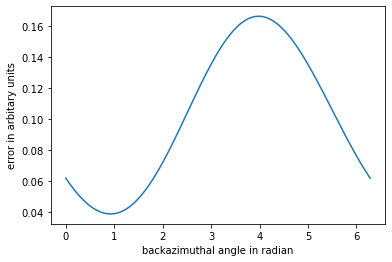

In [12]:
plt.plot(x,y)
plt.xlabel("backazimuthal angle in radian")
plt.ylabel("error in arbitary units")


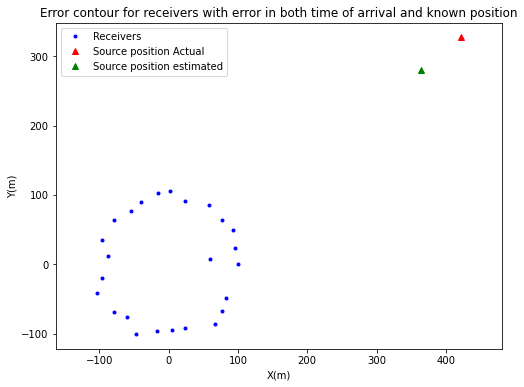

In [13]:
x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position

rec_pos_modified = np.zeros_like(rec_pos_act)
#rec_pos_modified[:] = rec_pos_act[:]  # Can modify later if required

plt.figure(figsize=(8,6))
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(src[0],src[1],'r^',label='Source position Actual')
#d=v*t_Rec_real[0]
#plt.plot(rec_pos_act+d*np.sin(phi_estimated),d*np.cos(phi_estimated),'g^',label='Source position estimated')
plt.plot(src_estimated[0],src_estimated[1],'g^',label='Source position estimated')
#plt.plot(d*np.sin(np.pi-phi_estimated),d*np.cos(np.pi-phi_estimated),'g^',label='Source position estimated')
#plt.plot(d*np.sin(np.pi/2-phi_estimated),d*np.cos(np.pi/2-phi_estimated),'g^',label='Source position estimated')
plt.plot()
plt.legend()
#plt.xlim(-500,500)
#plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')

plt.title('Error contour for receivers with error in both time of arrival and known position')
plt.show()

     

Cause of the error is because the estimated position assumes that first receiver (at index 0) is at origin ,\\
whereas this is not the case for circular configuration

Configurations tried so far:
linear,
gaussian(negative results),
circular

Noise introduced in position has standard deviation 5m; and that in time has standard deviation 5/v

In [14]:
def error_in_concurrency(v,n_rec,no_of_groups,n_in_this_grp,rec_loc,time):
    
    estimates_of_src=np.zeros(shape=(no_of_groups,2))
    #iteration for group
    for i in range(0,n_rec,n_in_this_grp):
        #print(i,i+n_in_this_grp)
        new_rec_loc=np.zeros(shape=(n_in_this_grp,2))
        for k in range(0,n_in_this_grp):
            new_rec_loc[k][0]=rec_loc[k+i][0]#-rec_loc[i][0] taken care in estimate-slowness()
            new_rec_loc[k][1]=rec_loc[k+i][1]#-rec_loc[i][1]
        phi,error,src_estimate_grp_i=estimate_slowness(v,n_in_this_grp,new_rec_loc,time[i:i+n_in_this_grp])
      
        # d_i=v*time[i]
        #print(d_i)
        #print(new_rec_loc)
        #print("phi: ", phi)
        #print("d_i*np.sin(phi): ",d_i*np.sin(phi),"d_i*np.cos(phi): ",d_i*np.cos(phi))
        #print("rec_loc[i][0]+d_i*np.sin(phi): ",rec_loc[i][0]+d_i*np.sin(phi),"rec_loc[i][1]+d_i*np.cos(phi): ",rec_loc[i][1]+d_i*np.cos(phi))
        estimates_of_src[int(i/n_in_this_grp)]=src_estimate_grp_i#(rec_loc[i][0]+d_i*np.sin(phi),rec_loc[i][1]+d_i*np.cos(phi))
        
    error_in_conc=0
        
    for j in range(0,no_of_groups):   
            error_in_conc+=np.sqrt((estimates_of_src[int(j)%int(no_of_groups)][0]-estimates_of_src[int(j+1)%int(no_of_groups)][0])**2\
    
                                + (estimates_of_src[int(j)%int(no_of_groups)][1]-estimates_of_src[int(j+1)%int(no_of_groups)][1])**2)
            

    return error_in_conc ,estimates_of_src      
    

In [15]:
distance_error,estimates=error_in_concurrency(v,n_rec,no_of_subsets,n_grp,rec_pos_mes,t_Rec_real)


In [16]:
print(estimates,distance_error)
estimates[1]
print(src_estimated)


[[366.00343572 276.56665711]
 [464.57651873 321.94869899]
 [440.15199549 372.75269894]
 [413.73252687 263.38092894]
 [445.68911485 450.86825478]] 659.2500173434491
(363.4158101353898, 279.9581749615099)


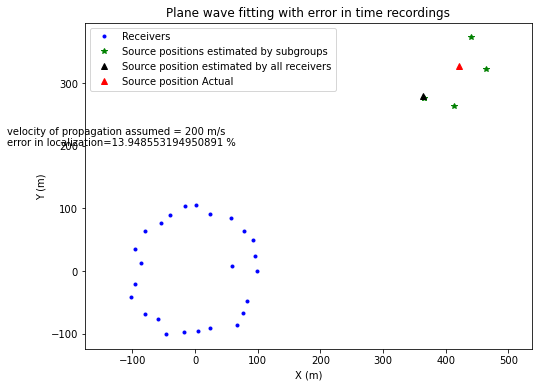

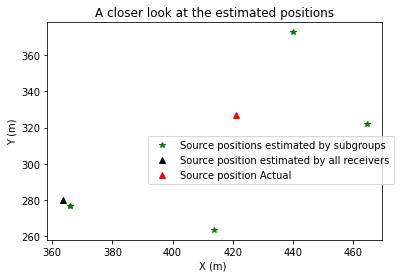

In [17]:
 x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position



plt.figure(figsize=(8,6))


plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
#plot2.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')

#d=v*t_Rec_real[n_grp]
plt.plot(estimates[0][0],estimates[0][1],'g*',label='Source positions estimated by subgroups')

for estimate_positions in estimates[:-1]:
    plt.plot(estimate_positions[0],estimate_positions[1],'g*')#label='Source positions estimated by subgroups')
#plt.plot(estimates[0][0],estimates[0][1],'g*',label='Source estimated by even indices')
#plt.plot(estimates[1][0],estimates[1][1],'k*',label='Source estimated by odd indices')
#plt.plot(src_estimated[0],src_estimated[1],'g^',label='Source estimated by all receivers')
plt.plot(src_estimated[0],src_estimated[1],'k^',label='Source position estimated by all receivers')
plt.plot(src[0],src[1],'r^',label='Source position Actual')

#plt.plot(d*np.sin(np.pi/2-phi_estimated),d*np.cos(np.pi/2-phi_estimated),'g^',label='Source position estimated')
plt.plot()
plt.xlabel('X (m)')
plt.ylabel( 'Y (m)')

plt.legend()
#plt.xlim(0,1)
#plt.ylim(3000,4000)
#plt.xlabel('X(m)')
#plt.ylabel('Y(m)')
plt.axis('equal')
plt.text(-300,200,f'velocity of propagation assumed = 200 m/s \nerror in localization={percent_err_dist} % ')

plt.title('Plane wave fitting with error in time recordings')
plt.show()

#zoome in view
#plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(estimates[0][0],estimates[0][1],'g*',label='Source positions estimated by subgroups')
for estimate_positions in estimates[:-1]:
    plt.plot(estimate_positions[0],estimate_positions[1],'g*',)#label='Source positions estimated by subgroups')
plt.plot(src_estimated[0],src_estimated[1],'k^',label='Source position estimated by all receivers')
plt.plot(src[0],src[1],'r^',label='Source position Actual')     
plt.title('A closer look at the estimated positions')
plt.xlabel('X (m) ')
plt.ylabel('Y (m)')
plt.legend(bbox_to_anchor = (1.05, 0.5))
plt.show()

In [18]:
 sum_of_errors(-np.sin(2*np.pi-phi)/v,-np.cos(2*np.pi-phi)/v,n_grp,new_rec_loc,t_diff[n_grp:2*n_grp])  

NameError: name 'phi' is not defined

In [ ]:
5.79425679785886-2*np.pi